In [ ]:
import ast
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
data = pd.read_csv("C:\\Users\\Lorenzo\\Downloads\\archive (2)\RAW_recipes.csv")

In [3]:
data.columns, len(data)

(Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
        'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
        'n_ingredients'],
       dtype='object'),
 231637)

In [4]:
str_ = lambda v: ast.literal_eval(v) if isinstance(v, str) else v

data_converted = data.copy()

for col in data.columns:
    if col not in ['name', 'description', 'submitted']:
        data_converted[col] = data[col].apply(str_)

data = data_converted.dropna()

In [5]:
print(data.head(20))

                                          name      id  minutes   
0   arriba   baked winter squash mexican style  137739       55  \
1             a bit different  breakfast pizza   31490       30   
2                    all in the kitchen  chili  112140      130   
3                           alouette  potatoes   59389       45   
4           amish  tomato ketchup  for canning   44061      190   
6                        aww  marinated olives   25274       15   
7               backyard style  barbecued ribs   67888      120   
9                      beat this  banana bread   75452       70   
10                 berry  good sandwich spread  109439        5   
11               better than sex  strawberries   42198     1460   
12             better then bush s  baked beans   67547     2970   
13                  boat house  collard greens  107517      525   
14                     calm your nerves  tonic   39959        5   
15            chicken lickin  good  pork chops   63986      50

In [6]:
print(len(data[data['steps'].apply(lambda x: len(x) == 0)]))
print(len(data[data['ingredients'].apply(lambda x: len(x) == 0)]))
print(len(data[data['tags'].apply(lambda x: len(x) == 0)]))

1
0
0


Remove this 1 recipe for which there is no steps (poor thing)

In [7]:
empty_steps = data['steps'].apply(lambda x: len(x) == 0)
data = data[~empty_steps]

Unique tags in tags column:

In [8]:
unique_tags = data['tags'].explode().unique()
print(sorted(unique_tags))
print(len(unique_tags))

['', '1-day-or-more', '15-minutes-or-less', '3-steps-or-less', '30-minutes-or-less', '4-hours-or-less', '5-ingredients-or-less', '60-minutes-or-less', 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.', 'a1-sauce', 'african', 'american', 'amish-mennonite', 'angolan', 'appetizers', 'apples', 'april-fools-day', 'argentine', 'artichoke', 'asian', 'asparagus', 'australian', 'austrian', 'avocado', 'bacon', 'baja', 'baked-beans', 'baking', 'bananas', 'bar-cookies', 'barbecue', 'bass', 'bean-soup', 'beans', 'beans-side-dishes', 'bear', 'beef', 'beef-barley-soup', 'beef-crock-pot', 'beef-kidney', 'beef-liver', 'beef-organ-meats', 'beef-ribs', 'beef-sauces', 'beef-sausage', 'beginner-cook', 'beijing', 'belgian', 'berries', 'beverages', 'birthday', 'biscotti', 'bisques-cream-soups', 'black-bean-soup', 'black-beans', 'blueberries', 'bok-choys', 'brazilian', 'bread-machine', 'bread-pudding', 'breads', 'breakfast', 'breakfast-casseroles', 'breakfast-eggs', 'breakfast-potatoes',

---

Before anything, let's remove those tags like 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.' or 'less_thansql:name_topics_of_recipegreater_than'...


In [9]:
remove = ['less_thansql:name_topics_of_recipegreater_than', 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.', 'free-of-something', 'low-in-something', 'high-in-something', 'time-to-make', 'condiments-etc', 'oamc-freezer-make-ahead', '', 'healthy-2']

In [10]:
def remove_tags(tag_list, to_remove):
    if isinstance(tag_list, list):
        return [tag for tag in tag_list if tag not in to_remove]
    return tag_list

data['tags'] = data['tags'].apply(lambda v: remove_tags(v, remove))

In [11]:
empty_tags = data['tags'].apply(lambda x: len(x) == 0)
print(data[empty_tags])

                                           name      id  minutes   
882                100  whole grain wheat bread  181106      195  \
1257              3 ingredient moroccan dry rub  505748        3   
1450                          4 layer pizza dip  506106       40   
1590                             5 minute salad  506141        5   
4867    american kitchen classic macaroni salad  506206       30   
...                                         ...     ...      ...   
220460                vanilla bean sweet butter  506062      130   
223541       vietnamese style broccoli stir fry  505811       15   
225804                         whiskey marinade  506238      245   
227866                winter wonderland martini  506222        5   
231003             zucchini baked in sour cream  505947       30   

        contributor_id   submitted tags   
882             339489  2006-08-08   []  \
1257             65502  2013-08-12   []   
1450            860538  2013-08-22   []   
1590       

In [12]:
data = data[~empty_tags]
print(len(data), len(data['tags'].explode().unique()))

226545 542


We have reduced the number of unique tags to 542

---

In [13]:
# Define the tag categories
time_tags = ['15-minutes-or-less', '30-minutes-or-less', '60-minutes-or-less', '4-hours-or-less', '1-day-or-more']

In [14]:
def check_time_tag(tags):
    time_tags_found = []
    for tag in tags:
        if tag in time_tags:
            time_tags_found.append(tag)
    return time_tags_found

data['time_tags'] = data['tags'].apply(check_time_tag)
data['tags'] = data['tags'].apply(lambda v: remove_tags(v, time_tags))

In [15]:
empty_tags = data['tags'].apply(lambda x: len(x) == 0)
data = data[~empty_tags]
print(len(data), len(data['tags'].explode().unique()))

226545 537


In [16]:
missing_time = data['time_tags'].apply(lambda v: len(v) == 0)
print(len(data[missing_time]))

10868


Not many time tags missing, can remove.

In [17]:
def assign_time_tag(minutes):
    if minutes < 15:
        return ['15-minutes-or-less']
    elif minutes < 30:
        return ['30-minutes-or-less']
    elif minutes < 60:
        return ['60-minutes-or-less']
    elif minutes < 240:
        return ['4-hours-or-less']
    else:
        return ['1-day-or-more']

data.loc[data['time_tags'] == 'unknown', 'time_tags'] = data.loc[data['time_tags'] == 'unknown', 'minutes'].apply(assign_time_tag)

data.loc[missing_time, 'time_tags'] = data.loc[missing_time, 'minutes'].apply(assign_time_tag)

In [18]:
print(len(data), 'missing time: ', len(data[data['time_tags'].apply(lambda x: len(x) == 0)]))

226545 missing time:  0


---

In [19]:
country_tags = ['african', 'american', 'angolan', 'argentine', 'asian', 'australian', 'austrian', 'baja', 'belgian', 'beijing', 'brazilian', 'british-columbian', 'cajun', 'californian', 'cambodian', 'canadian', 'caribbean', 'central-american', 'chilean', 'chinese', 'colombian', 'congolese', 'costa-rican', 'creole', 'cuban', 'czech', 'danish', 'dutch', 'ecuadorean', 'ecuadorian', 'egyptian', 'english', 'ethiopian', 'european', 'filipino', 'finnish', 'french', 'georgian', 'german', 'greek', 'guatemalan', 'hawaiian', 'honduran', 'hungarian', 'icelandic', 'indian', 'indonesian', 'iranian-persian', 'iraqi', 'irish', 'israeli', 'italian', 'jamaican', 'japanese', 'korean', 'kwanzaa', 'laotian', 'lebanese', 'libyan', 'malaysian', 'mexican', 'middle-eastern', 'midwestern', 'mongolian', 'moroccan', 'nepalese', 'nigerian', 'north-american', 'northeastern-united-states', 'norwegian', 'oaxacan', 'pacific-northwest', 'pakistani', 'palestinian', 'peruvian', 'polish', 'polynesian', 'portuguese', 'puerto rican', 'quebec', 'russian', 'saudi-arabian', 'scandinavian', 'scottish', 'south african', 'south-american', 'south-west-pacific', 'southern-united-states', 'southwestern-united-states', 'spanish', 'sudanese', 'swedish', 'swiss', 'tex-mex', 'thai', 'turkish', 'venezuelan', 'vietnamese', 'welsh', 'namibian', 'native-american', 'new-zealand']

In [20]:
print(len(country_tags), len(set(country_tags)))

102 102


In [21]:
def check_country_tag(tags):
    country_tags_found = []
    for tag in tags:
        if tag.lower() in country_tags or tag in country_tags:
            country_tags_found.append(tag)
    return country_tags_found

data['country_tags'] = data['tags'].apply(check_country_tag)
data['tags'] = data['tags'].apply(lambda v:remove_tags(v, country_tags))

In [22]:
empty_tags = data['tags'].apply(lambda x: len(x) == 0)
data = data[~empty_tags]
print(len(data), sorted(data['tags'].explode().unique()))

226545 ['3-steps-or-less', '5-ingredients-or-less', 'a1-sauce', 'amish-mennonite', 'appetizers', 'apples', 'april-fools-day', 'artichoke', 'asparagus', 'avocado', 'bacon', 'baked-beans', 'baking', 'bananas', 'bar-cookies', 'barbecue', 'bass', 'bean-soup', 'beans', 'beans-side-dishes', 'bear', 'beef', 'beef-barley-soup', 'beef-crock-pot', 'beef-kidney', 'beef-liver', 'beef-organ-meats', 'beef-ribs', 'beef-sauces', 'beef-sausage', 'beginner-cook', 'berries', 'beverages', 'birthday', 'biscotti', 'bisques-cream-soups', 'black-bean-soup', 'black-beans', 'blueberries', 'bok-choys', 'bread-machine', 'bread-pudding', 'breads', 'breakfast', 'breakfast-casseroles', 'breakfast-eggs', 'breakfast-potatoes', 'brewing', 'broccoli', 'broil', 'brown-bag', 'brown-rice', 'brownies', 'brunch', 'burgers', 'cabbage', 'cake-fillings-and-frostings', 'cakes', 'camping', 'candy', 'canning', 'cantonese', 'carrots', 'casseroles', 'catfish', 'cauliflower', 'celebrity', 'chard', 'cheese', 'cheesecake', 'cherries', 

In [23]:
country_missing = data[data['country_tags'].apply(lambda v: len(v) == 0)]
print(len(country_missing))

137371


Too many missing

In [24]:
print(country_missing.loc[:, ['name', 'tags']].head(20))

                                name   
2          all in the kitchen  chili  \
3                 alouette  potatoes   
9            beat this  banana bread   
10       berry  good sandwich spread   
11     better than sex  strawberries   
13        boat house  collard greens   
14           calm your nerves  tonic   
15  chicken lickin  good  pork chops   
17                    chinese  candy   
20            cream  of spinach soup   
21     cream  of spinach soup  vegan   
22           crispy crunchy  chicken   
23        deep fried dessert thingys   
24   easiest ever  hollandaise sauce   
26       fool the meat eaters  chili   
27             forgotten  minestrone   
28                   fried  potatoes   
30       get the sensation  brownies   
32              grilled  ranch bread   
33          grilled  venison burgers   

                                                 tags  
2   [course, preparation, main-dish, chili, crock-...  
3   [course, main-ingredient, preparation, occa

---

In [25]:
dietary_tags = [
    'a1-sauce', 'apples', 'artichoke', 'asparagus', 'avocado', 'bacon', 'baked-beans', 'bananas', 'bass', 'bean-soup', 'beans', 'beans-side-dishes', 'beef', 'beef-barley-soup', 'beef-crock-pot', 'beef-kidney', 'beef-liver', 'beef-organ-meats', 'beef-ribs', 'beef-sauces', 'beef-sausage', 'berries', 'black-bean-soup', 'black-beans', 'blueberries', 'bok-choys', 'bread-machine', 'bread-pudding', 'breads', 'broccoli', 'brown-rice', 'brownies', 'cabbage', 'cake-fillings-and-frostings', 'cakes', 'carrots', 'catfish', 'cauliflower', 'chard', 'cheese', 'cheesecake', 'cherries', 'chick-peas-garbanzos', 'chicken', 'chicken-breasts', 'chicken-crock-pot', 'chicken-livers', 'chicken-stew', 'chicken-stews', 'chicken-thighs-legs', 'chili', 'chocolate', 'chocolate-chip-cookies', 'chowders', 'chutneys', 'clams', 'coconut', 'cod', 'collard-greens', 'corn', 'crab', 'cranberry-sauce', 'crawfish', 'dairy-free', 'deer', 'desserts', 'desserts-fruit', 'diabetic', 'dietary', 'duck', 'duck-breasts', 'egg-free', 'eggplant', 'eggs', 'eggs-breakfast', 'eggs-dairy', 'elbow-macaroni', 'elk', 'fall', 'fish', 'freshwater-fish', 'frozen-desserts', 'fruit', 'fudge', 'gelatin', 'gluten-free', 'goose', 'grains', 'granola-and-porridge', 'grapes', 'green-yellow-beans', 'greens', 'ground-beef', 'gumbo', 'halibut', 'ham', 'ham-and-bean-soup', 'healthy', 'herb-and-spice-mixes', 'high-calcium', 'high-fiber', 'high-in-something-diabetic-friendly', 'high-protein', 'ice-cream', 'infant-baby-friendly', 'irish-st-patricks-day', 'kid-friendly', 'kiwifruit', 'kosher', 'lactose', 'lamb-sheep', 'lamb-sheep-main-dish', 'lasagna', 'lasagne', 'lemon', 'lentils', 'lettuces', 'lime', 'lobster', 'long-grain-rice', 'low-calorie', 'low-carb', 'low-cholesterol', 'low-fat', 'low-protein', 'low-saturated-fat', 'low-sodium', 'macaroni-and-cheese', 'mahi-mahi', 'mango', 'manicotti', 'meat', 'meatballs', 'meatloaf', 'medium-grain-rice', 'melons', 'mushroom-soup', 'mushrooms', 'mussels', 'no-shell-fish', 'non-alcoholic', 'nut-free', 'nuts', 'oatmeal', 'octopus', 'onions', 'orange-roughy', 'oranges', 'oysters', 'paleo', 'papaya', 'pasta', 'pasta-elbow-macaroni', 'pasta-rice-and-grains', 'pasta-rice-and-grains-elbow-macaroni', 'pasta-salad', 'pasta-shells', 'peaches', 'peanut-butter', 'pears', 'penne', 'peppers', 'perch', 'pheasant', 'pickeral', 'pineapple', 'pitted-fruit', 'plums', 'pork', 'pork-chops', 'pork-crock-pot', 'pork-loin', 'pork-loins', 'pork-loins-roast', 'pork-ribs', 'pork-sausage', 'potatoes', 'poultry', 'prepared-potatoes', 'pumpkin', 'quail', 'rabbit', 'raspberries', 'refrigerator', 'rice', 'roast', 'roast-beef', 'salad-dressings', 'salads', 'salmon', 'salsas', 'saltwater-fish', 'savory', 'scallops', 'seafood', 'shellfish', 'shrimp', 'shrimp-main-dish', 'simply-potatoes', 'simply-potatoes2', 'sole-and-flounder', 'soy-tofu', 'spaghetti', 'spaghetti-sauce', 'spinach', 'squash', 'squid', 'steak', 'steaks', 'strawberries', 'stuffings-dressings', 'sugar-cookies', 'sweet-sauces', 'tempeh', 'tilapia', 'tomatoes', 'tropical-fruit', 'trout', 'tuna', 'turkey', 'turkey-breasts', 'turkey-burgers', 'veal', 'vegan', 'vegetables', 'vegetarian', 'veggie-burgers', 'white-rice', 'whitefish', 'whole-chicken', 'whole-duck', 'whole-turkey', 'wild-game', 'wings', 'yams-sweet-potatoes', 'yeast', 'zucchini'
]
print(len(dietary_tags), len(set(dietary_tags)))

237 237


In [26]:
def check_dietary_tags(tags):
    dietary_tags_found = []
    for tag in tags:
        if tag.lower() in dietary_tags or tag in dietary_tags:
            dietary_tags_found.append(tag)
    return dietary_tags_found


data['dietary_tags'] = data['tags'].apply(check_dietary_tags)
data['tags'] = data['tags'].apply(lambda v: remove_tags(v, dietary_tags))
empty_tags = data['tags'].apply(lambda x: len(x) == 0)
data = data[~empty_tags]
print(len(data), sorted(data['tags'].explode().unique()))

226521 ['3-steps-or-less', '5-ingredients-or-less', 'amish-mennonite', 'appetizers', 'april-fools-day', 'baking', 'bar-cookies', 'barbecue', 'bear', 'beginner-cook', 'beverages', 'birthday', 'biscotti', 'bisques-cream-soups', 'breakfast', 'breakfast-casseroles', 'breakfast-eggs', 'breakfast-potatoes', 'brewing', 'broil', 'brown-bag', 'brunch', 'burgers', 'camping', 'candy', 'canning', 'cantonese', 'casseroles', 'celebrity', 'chinese-new-year', 'christmas', 'cinco-de-mayo', 'citrus', 'clear-soups', 'cobblers-and-crisps', 'cocktails', 'coffee-cakes', 'college', 'comfort-food', 'cookies-and-brownies', 'cooking-mixes', 'copycat', 'course', 'crock-pot-main-dish', 'crock-pot-slow-cooker', 'crusts-pastry-dough-2', 'cuisine', 'cupcakes', 'curries', 'deep-fry', 'dehydrator', 'desserts-easy', 'dinner-party', 'dips', 'dips-lunch-snacks', 'dips-summer', 'drop-cookies', 'easter', 'easy', 'equipment', 'fathers-day', 'fillings-and-frostings-chocolate', 'finger-food', 'flat-shapes', 'food-processor-bl

In [27]:
data['special_tags'] = data['tags']
data = data.drop(columns=['tags'])

In [28]:
print(data['ingredients'])
data['ingredients_tags'] = data['ingredients'].copy()

def update_ingredients_tags(row):
    updated_tags = []
    not_in_dietary = lambda i: not (i in row['dietary_tags'])
    not_in_special = lambda i: not (i in row['special_tags'])

    for ingredient in row['ingredients']:
        if not_in_dietary(ingredient) and not_in_special(ingredient):
            updated_tags.append(ingredient)
    return updated_tags

data['ingredients_tags'] = data.apply(update_ingredients_tags, axis=1)

0         [winter squash, mexican seasoning, mixed spice...
1         [prepared pizza crust, sausage patty, eggs, mi...
2         [ground beef, yellow onions, diced tomatoes, t...
3         [spreadable cheese with garlic and herbs, new ...
4         [tomato juice, apple cider vinegar, sugar, sal...
                                ...                        
231632    [celery, onion, green sweet pepper, garlic clo...
231633    [paprika, salt, garlic powder, onion powder, d...
231634    [hard-cooked eggs, mayonnaise, dijon mustard, ...
231635    [butter, eagle brand condensed milk, light bro...
231636    [granulated sugar, shortening, eggs, flour, cr...
Name: ingredients, Length: 226521, dtype: object


In [29]:
print(data['ingredients_tags'].explode().nunique())
data = data.drop(columns=['ingredients'])
print(data)

14751
                                                name      id  minutes   
0         arriba   baked winter squash mexican style  137739       55  \
1                   a bit different  breakfast pizza   31490       30   
2                          all in the kitchen  chili  112140      130   
3                                 alouette  potatoes   59389       45   
4                 amish  tomato ketchup  for canning   44061      190   
...                                              ...     ...      ...   
231632                                   zydeco soup  486161       60   
231633                              zydeco spice mix  493372        5   
231634                     zydeco ya ya deviled eggs  308080       40   
231635        cookies by design   cookies on a stick  298512       29   
231636  cookies by design   sugar shortbread cookies  298509       20   

        contributor_id   submitted   
0                47892  2005-09-16  \
1                26278  2002-06-17   
2  

In [30]:
print(data.loc[:, ['special_tags', 'time_tags', 'country_tags', 'dietary_tags', 'ingredients_tags']].head())

                                        special_tags             time_tags   
0  [course, main-ingredient, cuisine, preparation...  [60-minutes-or-less]  \
1  [course, main-ingredient, cuisine, preparation...  [30-minutes-or-less]   
2  [course, preparation, main-dish, crock-pot-slo...     [4-hours-or-less]   
3  [course, main-ingredient, preparation, occasio...  [60-minutes-or-less]   
4  [weeknight, course, main-ingredient, cuisine, ...     [4-hours-or-less]   

                                        country_tags   
0                          [north-american, mexican]  \
1  [north-american, american, northeastern-united...   
2                                                 []   
3                                                 []   
4  [north-american, american, northeastern-united...   

                                        dietary_tags   
0    [vegetables, fall, vegetarian, dietary, squash]  \
1                [pork, kid-friendly, dietary, meat]   
2                         

In [31]:
print(list(data.special_tags.explode().unique()))

['course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'side-dishes', 'easy', 'holiday-event', 'winter', 'christmas', 'seasonal', 'breakfast', 'main-dish', 'oven', 'pizza', 'equipment', 'crock-pot-slow-cooker', 'dinner-party', 'easter', 'stove-top', 'new-years', 'thanksgiving', 'independence-day', 'st-patricks-day', 'valentines-day', 'inexpensive', 'brunch', 'superbowl', 'presentation', 'served-hot', 'weeknight', 'canning', 'heirloom-historical', 'amish-mennonite', 'number-of-servings', 'technique', 'appetizers', 'freezer', 'spicy', 'copycat', 'super-bowl', 'novelty', 'taste-mood', 'sweet', 'quick-breads', '5-ingredients-or-less', '3-steps-or-less', 'pies-and-tarts', 'pies', 'comfort-food', 'potluck', 'to-go', 'deep-fry', 'candy', 'one-dish-meal', 'bisques-cream-soups', 'soups-stews', 'spring', 'food-processor-blender', 'small-appliance', 'lunch', 'beginner-cook', 'very-low-carbs', 'sauces', 'savory-sauces', 'no-cook', 'cooking-mixes', 'served-cold', 'grilling', 'picnic', 

In [32]:
print(list(data.country_tags.explode().unique()))

['north-american', 'mexican', 'american', 'northeastern-united-states', nan, 'canadian', 'south-west-pacific', 'hawaiian', 'southwestern-united-states', 'asian', 'indian', 'californian', 'german', 'european', 'italian', 'midwestern', 'southern-united-states', 'indonesian', 'polish', 'chinese', 'british-columbian', 'danish', 'scandinavian', 'swiss', 'swedish', 'french', 'african', 'cajun', 'creole', 'kwanzaa', 'australian', 'caribbean', 'central-american', 'english', 'quebec', 'middle-eastern', 'lebanese', 'greek', 'pacific-northwest', 'south-american', 'russian', 'baja', 'japanese', 'native-american', 'spanish', 'irish', 'oaxacan', 'thai', 'polynesian', 'iraqi', 'saudi-arabian', 'pakistani', 'scottish', 'tex-mex', 'new-zealand', 'colombian', 'welsh', 'czech', 'filipino', 'cuban', 'belgian', 'costa-rican', 'guatemalan', 'honduran', 'finnish', 'moroccan', 'iranian-persian', 'dutch', 'turkish', 'portuguese', 'hungarian', 'georgian', 'brazilian', 'nigerian', 'ethiopian', 'sudanese', 'congo

In [33]:
print(list(data.dietary_tags.explode().unique()))

['vegetables', 'fall', 'vegetarian', 'dietary', 'squash', 'pork', 'kid-friendly', 'meat', 'chili', 'eggs-dairy', 'potatoes', 'cheese', 'fruit', 'vegan', 'pork-ribs', 'savory', 'breads', 'tropical-fruit', 'bananas', 'low-protein', 'healthy', 'low-sodium', 'desserts', 'berries', 'strawberries', 'beans', 'greens', 'collard-greens', nan, 'pork-chops', 'beef', 'lactose', 'cauliflower', 'low-cholesterol', 'low-calorie', 'low-carb', 'spinach', 'low-saturated-fat', 'high-calcium', 'eggs', 'herb-and-spice-mixes', 'peppers', 'poultry', 'chicken', 'gluten-free', 'black-beans', 'chocolate', 'brownies', 'ground-beef', 'wild-game', 'deer', 'low-fat', 'frozen-desserts', 'salads', 'refrigerator', 'pasta', 'pasta-rice-and-grains', 'cakes', 'nuts', 'pineapple', 'corn', 'yeast', 'lasagna', 'chicken-breasts', 'diabetic', 'infant-baby-friendly', 'apples', 'roast', 'veal', 'cheesecake', 'grains', 'kosher', 'high-protein', 'mushrooms', 'seafood', 'fish', 'tuna', 'saltwater-fish', 'elbow-macaroni', 'chicken-t

In [34]:
print(list(data.ingredients_tags.explode().unique()))

['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt', 'prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese', 'ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'lettuce', 'cheddar cheese', 'spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'red wine vinegar', 'pepper', 'red bell pepper', 'yellow bell pepper', 'tomato juice', 'apple cider vinegar', 'sugar', 'clove oil', 'cinnamon oil', 'dry mustard', 'fennel seeds', 'green olives', 'ripe olives', 'garlic', 'peppercorn', 'orange rind', 'orange juice', 'red chile', 'extra virgin olive oil', 'pork spareribs', 'soy sauce', 'fresh garlic', 'fresh ginger', 'fresh coarse ground black pepper', 'fresh cilantro leaves', 'tomato sauce', 'brown sugar', 'yellow onion', 'white vinegar', 'a.1. original sauce', 'liquid smoke', 'cracked b

---

In [35]:
data = data.drop(columns=['contributor_id', 'submitted', 'nutrition', 'n_steps'])

**DROP** these columns that we can retrieve later, given recipe_id stays in the refactored db too.
**KEEP** steps and description to give explanation of recipe afterwards

lil check:

In [36]:
import numpy as np
tags_columns =  ['special_tags', 'time_tags', 'country_tags', 'dietary_tags', 'ingredients_tags']
all_tags = []

def len_tags(row):
    num_tags = 0
    for column in tags_columns:
        all_tags.extend(row[column].copy())
        num_tags += len(row[column])
    return num_tags

total_num_tags = np.sum(data.apply(len_tags, axis=1))

print("Total num. of tags in db: ", total_num_tags)
print("Total unique tags: ", len(list(set(all_tags))))
print("Average num. of tags per recipe: ", total_num_tags/len(data))

Total num. of tags in db:  5700699
Total unique tags:  15193
Average num. of tags per recipe:  25.1663157058286


---

Save cleaned db to csv file

In [37]:
print('empty country tags: ', len(data[data['country_tags'].apply(lambda v: len(v) == 0)]))

empty country tags:  137347


In [38]:
df = data.sort_values(by='country_tags', key=lambda x: x.apply(lambda t: t[0] if t else ''))
df.to_csv('cleaned_recipes.csv', index=False)

In [39]:
df = pd.read_csv('cleaned_recipes.csv')
empty_country = df['country_tags'].apply(eval).apply(lambda x: len(x) == 0)
print(len(df[~empty_country]))

89174


In [40]:
df[~empty_country].to_csv('cleaned_recipes_with_country.csv', index=False)

In [41]:
df = pd.read_csv('cleaned_recipes_with_country.csv')

In [42]:
pd.reset_option('display.max_columns')

In [43]:
import random

random_recipe = random.randint(0, len(df))
print(df.iloc[random_recipe])

name                                          fiesta black bean salad
id                                                             276478
minutes                                                            10
steps               ['gently toss together corn , red onion , red ...
description         this is an easy, and colorful, side dish.  i l...
n_ingredients                                                      12
time_tags                                      ['15-minutes-or-less']
country_tags                            ['north-american', 'mexican']
dietary_tags        ['beans', 'vegetables', 'vegan', 'vegetarian',...
special_tags        ['course', 'main-ingredient', 'cuisine', 'prep...
ingredients_tags    ['red onion', 'red bell pepper', 'black beans'...
Name: 62861, dtype: object


---
---

In [63]:
# Function to create binary matrix, perform PCA, and plot explained variance
def process_tags(data, column, variance_threshold=0.9):
    # Step 1: Explode the lists and create the binary matrix for the specified tag category
    exploded_tags = data[column].explode().dropna().unique()
    mlb = MultiLabelBinarizer(classes=exploded_tags)
    binary_matrix = mlb.fit_transform(data[column]).astype(np.float32)  # Use float32 instead of float64

    # Step 2: Perform PCA and determine number of components to explain the desired variance
    pca = PCA()
    pca.fit(binary_matrix)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain the variance_threshold
    num_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
    plt.axvline(num_components, color='r', linestyle='--', label=f'{num_components} components')
    plt.title(f'Explained Variance by Number of Components for {column}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Step 3: Extract the principal components and their associated single tags
    pca = PCA(n_components=num_components)
    pca.fit(binary_matrix)
    principal_components = pca.components_

    # Get the single most significant tag for each principal component
    tag_names = mlb.classes_
    selected_tags = set()
    components_tags = {}

    for i, component in enumerate(principal_components):
        sorted_indices = np.argsort(np.abs(component))[::-1]  # Indices sorted by absolute value
        for index in sorted_indices:
            tag = tag_names[index]
            if tag not in selected_tags:
                components_tags[f'Component {i+1}'] = tag
                selected_tags.add(tag)
                break

    return num_components, components_tags


Processing special_tags...


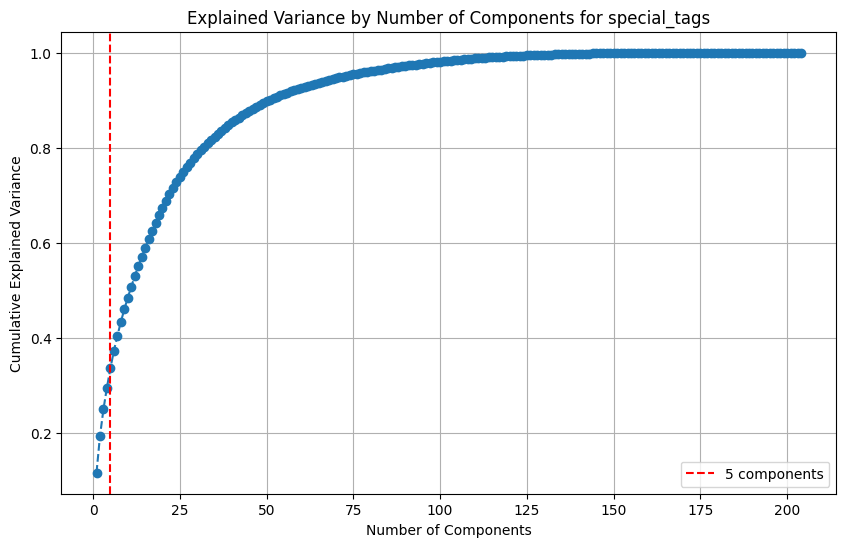

Number of components needed to explain 30.0% variance for special_tags: 5
Component 1: occasion
Component 2: easy
Component 3: main-dish
Component 4: equipment
Component 5: number-of-servings

Processing time_tags...


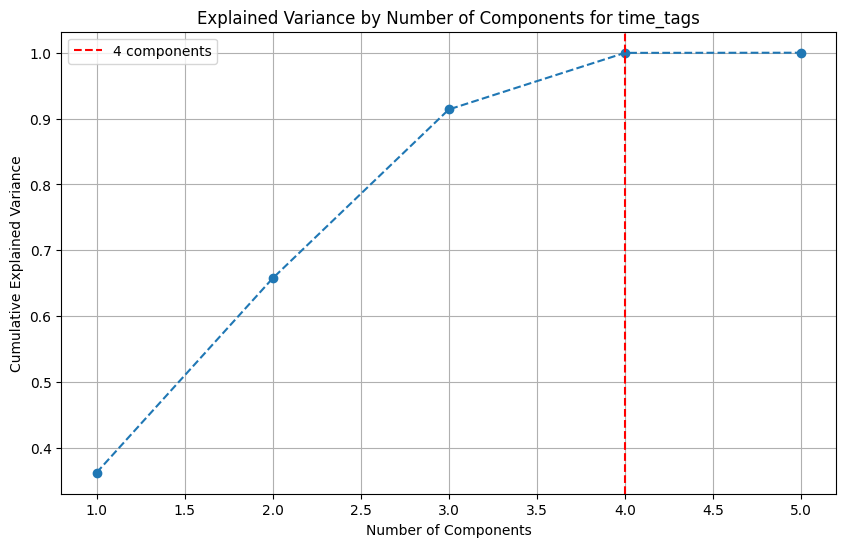

Number of components needed to explain 99.0% variance for time_tags: 4
Component 1: 60-minutes-or-less
Component 2: 30-minutes-or-less
Component 3: 15-minutes-or-less
Component 4: 1-day-or-more

Processing country_tags...


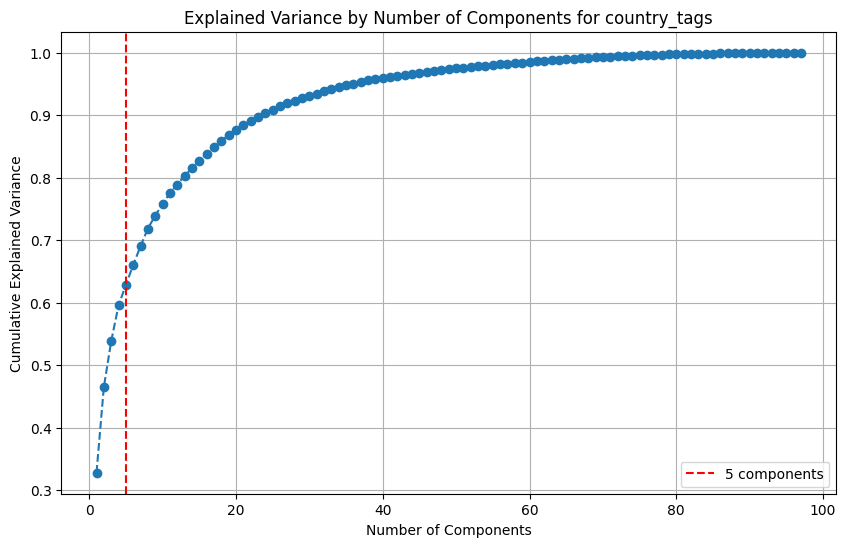

Number of components needed to explain 60.0% variance for country_tags: 5
Component 1: north-american
Component 2: european
Component 3: asian
Component 4: american
Component 5: south-west-pacific

Processing dietary_tags...


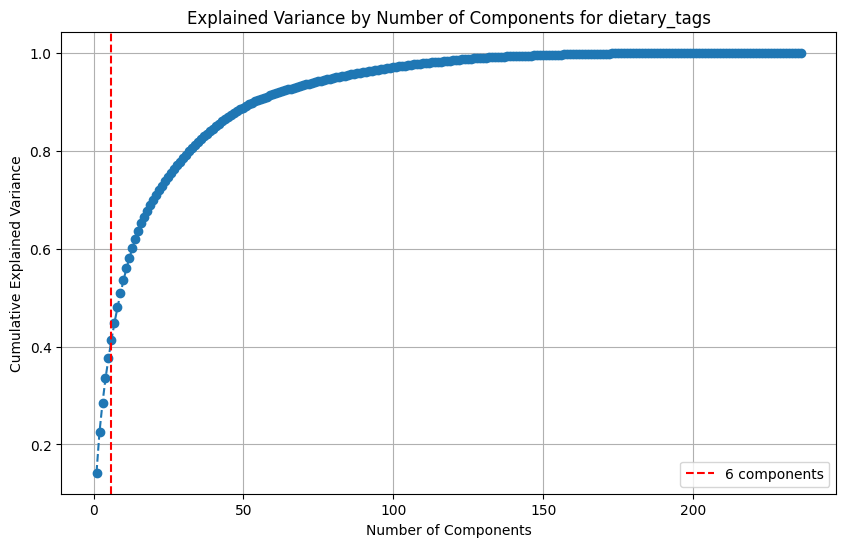

Number of components needed to explain 40.0% variance for dietary_tags: 6
Component 1: low-cholesterol
Component 2: meat
Component 3: vegetables
Component 4: dietary
Component 5: low-carb
Component 6: pasta-rice-and-grains


In [72]:
variances = [0.3, .99, 0.6, 0.4, 0]
for i, column in enumerate(tags_columns):
    if variances[i] <= 0:
        continue
    print(f'\nProcessing {column}...')
    num_components, components_tags = process_tags(data, column, variance_threshold=variances[i])
    print(f'Number of components needed to explain {variances[i]*100}% variance for {column}: {num_components}')
    for component, tag in components_tags.items():
        print(f'{component}: {tag}')

In [73]:
recipe_tags = pd.read_csv('recipe_tag_df.csv')
recipe_tags.head(20)

MemoryError: 